In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nlppreprocess import NLP # pip install nlppreprocess
import en_core_web_sm
from nltk import pos_tag

#Model Selection and Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
dataset = pd.read_csv("train.csv")
final_test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
dataset.shape

(15819, 3)

In [4]:
final_test.shape

(10546, 2)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
dataset.head(2)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103


In [7]:
final_test.head(2)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326


In [8]:
y = dataset['sentiment']
X = dataset.drop(columns=['sentiment', 'tweetid'])
F_test = final_test.drop(columns='tweetid')

In [9]:
X.head(2)

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...


In [10]:
y.unique()

array([ 1,  2,  0, -1], dtype=int64)

In [11]:
# Working_text to test
text = X.iloc[6,0]
print(text)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


In [12]:
working_df = dataset.copy()

In [13]:
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']] # Labeling the target

In [14]:
working_df.head()

,sentiment,message,tweetid
0,Positive,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Positive,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Positive,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Positive,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [15]:
working_df.describe()

,tweetid
count,15819.000000
mean,501719.433656
std,289045.983132
min,6.000000
25%,253207.500000
50%,502291.000000
75%,753769.000000
max,999888.000000


In [16]:
help(plt.pie)

Help on function pie in module matplotlib.pyplot:

pie(x, explode=None, labels=None, colors=None, autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=None, radius=None, counterclock=True, wedgeprops=None, textprops=None, center=(0, 0), frame=False, rotatelabels=False, *, data=None)
    Plot a pie chart.
    
    Make a pie chart of array *x*.  The fractional area of each wedge is
    given by ``x/sum(x)``.  If ``sum(x) < 1``, then the values of *x* give
    the fractional area directly and the array will not be normalized. The
    resulting pie will have an empty wedge of size ``1 - sum(x)``.
    
    The wedges are plotted counterclockwise, by default starting from the
    x-axis.
    
    Parameters
    ----------
    x : array-like
        The wedge sizes.
    
    explode : array-like, optional, default: None
        If not *None*, is a ``len(x)`` array which specifies the fraction
        of the radius with which to offset each wedge.
    
    labels : list,

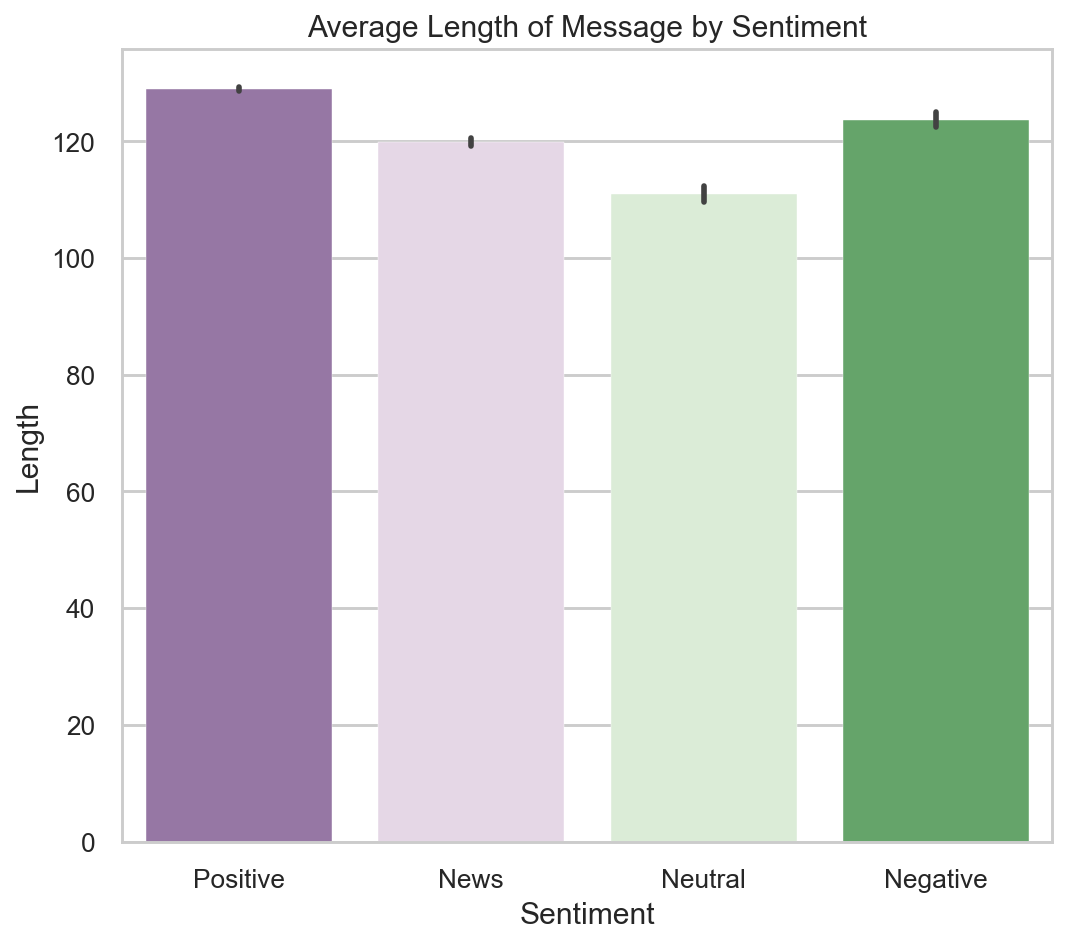

In [17]:
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

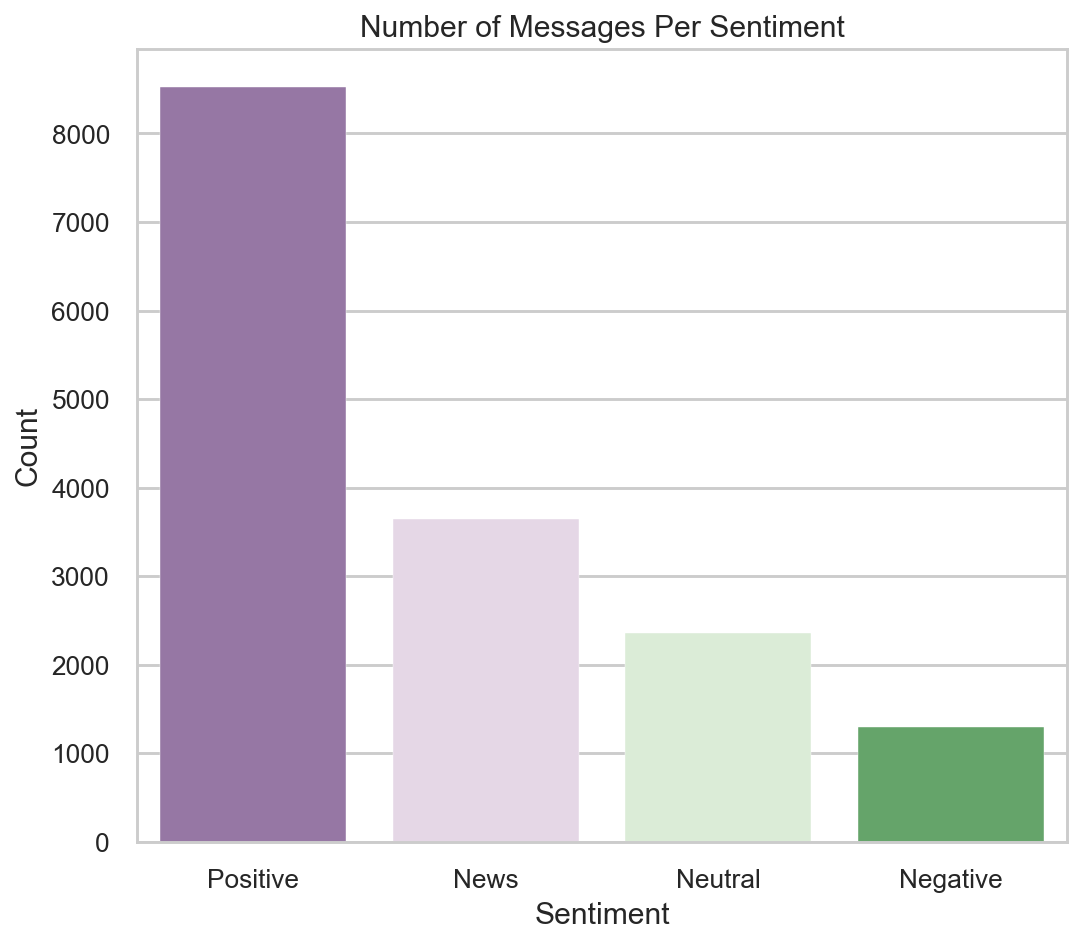

In [18]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

Preprocessing

firstly, i want to see if any of the users are repeated.

In [19]:
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in X.message]


In [20]:
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [21]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [22]:
repeated_tags_rate = round(counts['message'][counts['message'] > 1].sum() * 100/len(counts['message']), 0)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

86.0 percent of the data are from repeated tags


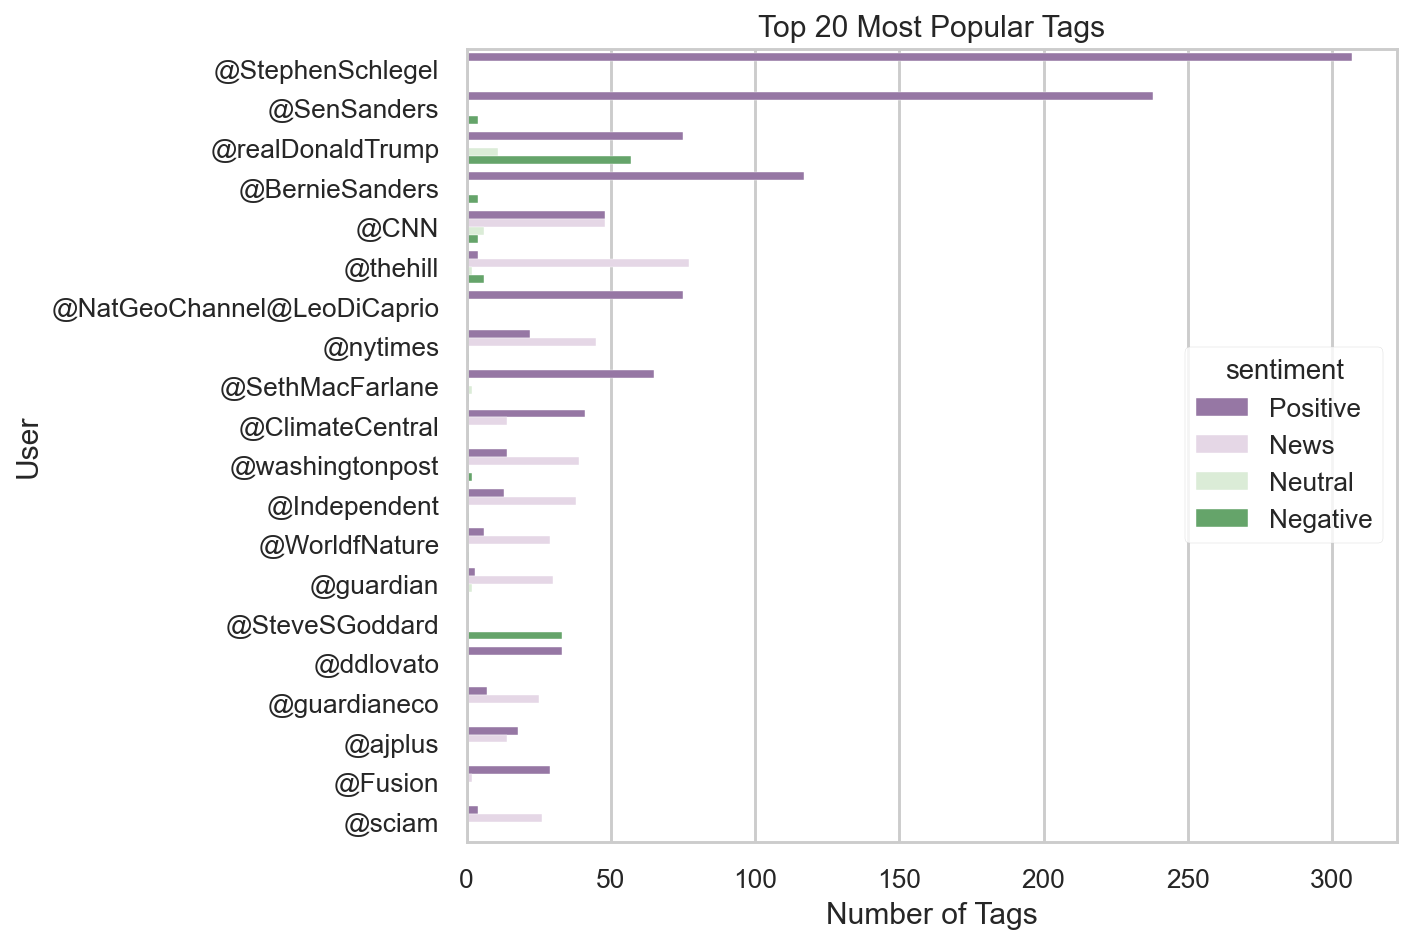

In [23]:

sns.countplot(y="users", hue="sentiment", data=working_df,
              order=working_df.users.value_counts().iloc[:20].index, palette='PRGn') 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

In [24]:
from wordcloud import WordCloud, STOPWORDS

We will not, therefore, be removing users, as we can see that they have a contribute to the analysis

pip install nlppreprocess

In [25]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('shouldnt')

'should not'

In [26]:
stop_words = nlp.print_stopwords()

{'or', 'of', 'this', 'did', 'an', 'if', 'has', 'down', 'here', 'same', 'have', 'i', 'be', 'she', 'were', 'a', 'does', 'some', 'it', 'the', 'all', 'until', 'for', 'own', 'on', 'whom', 'that', 'other', 'do', 'why', 'mine', 'below', 'both', 'who', 'while', 'above', 'at', 'between', 'itself', 'me', 'to', 'he', 'any', 'so', 'was', 'is', 'as'}


In [27]:
nlp.process('There is no good here')

'There no good'

In [28]:
def cleaner(line):

    # Removes RT, url and trailing white spaces
    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) 

    # Removes puctuation
    punctuation = re.compile("[.;:!\'’‘“”?,\"()\[\]]")
    tweet = punctuation.sub("", line.lower()) 

    # Removes stopwords
    nlp_for_stopwords = NLP(replace_words=True, remove_stopwords=True, remove_numbers=True, remove_punctuations=False) 
    tweet = nlp_for_stopwords.process(tweet) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52

    # tokenisation
    # We used the split method instead of the word_tokenise library because our tweet is already clean at this point
    # and the twitter data is not complicated
    tweet = tweet.split() 

    # POS 
    pos = pos_tag(tweet)

    # Stemming
    # stemmer = PorterStemmer()
    # tweet = ' '.join([stemmer.stem(word) for word in tweet])
    # pos_only = [p for w, p in pos]
    # new_pos = zip(tweet.split(), pos_only)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = ' '.join([lemmatizer.lemmatize(word, po[0].lower()) if po[0].lower() in ['n', 'r', 'v', 'a'] else word for word, po in pos])
    # tweet = ' '.join([lemmatizer.lemmatize(word, 'v') for word in tweet])

    return tweet

In [29]:
text1 = cleaner(text)
print('BEFORE')
print(text, '\n'*2)
print('AFTER')
print(text1)
# In the tweet below, you can see that "not" was added and kept, because the word is significant

BEFORE
RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R 


AFTER
@thenation mike penny not believe in global warming smoking cause lung cancer


In [30]:
X1 = X.message.apply(cleaner)

In [31]:
F_test1 = F_test.message.apply(cleaner)

In [32]:
# cv = CountVectorizer()
# X2 = cv.fit_transform(X1)
# F_test2 = cv.transform(F_test1)

In [33]:
from imblearn.over_sampling import SMOTE

# Separate input features and target

# setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=27)

# sm = SMOTE(random_state=27, sampling_strategy='not majority', n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)


In [34]:
# help(SMOTE)

In [35]:
X1.head()

0    polyscimajor epa chief not think carbon dioxid...
1    its not like we lack evidence anthropogenic gl...
2    @rawstory researcher say we three year act cli...
3    #todayinmaker# wire pivotal year in war climat...
4    @soynoviodetodas its and racist sexist climate...
Name: message, dtype: object

In [36]:
tok = [line.split() for line in X1]

In [37]:
corpus = [' '.join(i) for i in tok]

In [122]:
from sklearn.model_selection    import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing      import PolynomialFeatures
from xgboost.sklearn            import XGBClassifier, XGBRFClassifier

models = [XGBRFClassifier()]


for mod in models:
    estimator = []
    estimator.append(('cv', CountVectorizer()))
    estimator.append(('tfidf', TfidfTransformer()))
    # estimator.append(('pf', PolynomialFeatures()))
    estimator.append(('model', mod))
    model = Pipeline(estimator)
    
    kfold = KFold(n_splits=5, random_state=27)

    results = cross_val_score(model, X1, y, cv=kfold, scoring='f1_weighted', n_jobs=-1)
    print(mod)
    print('results = ', results,'\nmean = ', np.mean(results), '\nstd = ', np.std(results))
    print('\n'*2)

XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bytree=None, gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                max_delta_step=None, max_depth=None, min_child_weight=None,
                missing=nan, monotone_constraints=None, n_estimators=100,
                n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', random_state=None, reg_alpha=None,
                scale_pos_weight=None, tree_method=None,
                validate_parameters=None, verbosity=None)
results =  [0.56089824 0.56848165 0.55454824 0.5697201  0.58216379] 
mean =  0.5671624028169429 
std =  0.009291722383748077





In [39]:
# help(KFold)

In [40]:
sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [41]:
# estimator1 = []
# estimator1.append(('cv', CountVectorizer()))
# estimator1.append(('tfidf', TfidfTransformer()))
# estimator1.append(('model', LogisticRegression(C=8)))
# model = Pipeline(estimator1)
# model.fit(X1, y)
# y_pred = model.predict(F_test1)
# v1 = sample.copy()
# v1['tweetid'] = final_test['tweetid']
# v1['sentiment'] = y_pred
# v1.to_csv('log_c8_unbalanced.csv', index=False)

In [42]:
# v1.head()

In [43]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [44]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [45]:
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                # "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                # "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        # "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            # "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    # "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

In [46]:
# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [47]:
for selected_classifier in ['Ridge']:
    classifier = classifiers[selected_classifier]
    param_grid = parameters[selected_classifier]

    estimator = []
    estimator.append(('cv', CountVectorizer()))
    estimator.append(('tfidf', TfidfTransformer()))
    # estimator.append(('model', classifier))
    pipe = Pipeline(estimator)
    X2 = pipe.fit_transform(X1)

    pgrid = param_grid.copy()
    for k in param_grid.keys():
        new_key = k
        pgrid[k[len('classifier__'):]] = pgrid.pop(k)

    kfold = KFold(n_splits=5, random_state=27)

    gscv = GridSearchCV(classifier, pgrid, cv = 2,  n_jobs= -1, verbose = 1, scoring = "f1_weighted")

    gscv.fit(X2, y)
    gscv.best_score_

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  2.8min finished


In [48]:
gscv.best_score_

0.7028473341741359

In [49]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [50]:
pgrid = param_grid.copy()

In [51]:
pgrid = param_grid.copy()
for k in param_grid.keys():
    new_key = k
    pgrid[k[len('classifier__'):]] = pgrid.pop(k)

In [52]:
pgrid

{'alpha': [1e-07,
  1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  0.25,
  0.5,
  0.75,
  1.0]}